# Positive wavefunctions: TFIM

In this tutorial, we discuss
the application of QuCumber to wavefunctions that are positive and real-valued
in the computational basis. That is, the expansion of the wave function has all
positive and real coefficients in the basis in which experiments are performed.
In this case, QuCumber has a highly efficient parallelizable method to determine
the most likely state consistent with the given measurements. As an example, we
demonstrate how to train and sample a QuCumber RBM model with measurements from
the one-dimensional transverse-field Ising model (TFIM).

### Transverse field Ising model
The Hamiltonian for the transverse-field Ising model (TFIM) is given
by
\begin{equation}
	\mathcal{H} = -J\sum_i \sigma^z_i \sigma^z_{i+1} - h \sum_i
\sigma^x_i
\end{equation}
where $\sigma^{\alpha}_i$ is a spin-1/2
Pauli operator on site $i$, with $\alpha=x,y,z$. We consider the critical point
where $J=h=1$, which is the most difficult state to reconstuct.

For training
data, we use a synthetic data set consisting of $N=10,000$ measurements in the
$\sigma^z$-basis for 10 spins, generated with standard numerical techniques. The
example dataset is provided in tfim1d_train_samples.txt. As usual, spins are
represented in binary notation with zeros denoting spin-down, and one denoting
spin-up. 

##### Code 
To begin the tutorial, we first load the required Python
packages with common abbreviations.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from qucumber.nn_states import PositiveWavefunction
from qucumber.callbacks import MetricEvaluator
import qucumber.utils.training_statistics as ts
import qucumber.utils.data as data

import quantum_ising_chain
from quantum_ising_chain import TFIMChainEnergy, TFIMChainMagnetization

## Positive wave function object

The central object of QuCumber is the representation of the wavefunction. In the case of a completely positive wavefunction, the representation is an RBM with binary visible and hidden units.
This Python class *PositiveWavefunction* serves this purpose.
To instanciate a positive wavefunction, one needs to specify the number of visible and hidden units in the RBM.
The number of visible units (*num_visible*) is given by the size of the physical system, i.e., the number of spins or qubits.
In contrast, the number of hidden units (*num_hidden*) can be varied to change the expressiveness of the neural network.
Errors in the representation can be systematically improved by increasing the number of hidden units and consequently
the number of parameters (weights and biases) in the network.
The quality of the reconstruction will depend on the specific wavefunction and the ratio $\alpha = $*num_hidden*/*num_visible*.
Typically, in our studies $\alpha = 1$ leads to good approximations of positive real wavefunctions.
In the general case, however, the value of $\alpha$ required for a given wavefunction reconstruction should be explored and adjusted by the user.

#### Code
The following code snippet instantiates a *PositiveWavefunction* object with 10 visible units and 10 hidden units.
The biases are initialized to zero, and the weights are initialized randomly according to a normal distribution with zero mean and a variance of *nm_visible*$^{(-1)}$.

One may also choose to run this tutorial on a GPU by
adding in "gpu = True" as an argument to **PositiveWavefunction**.

In [2]:
nn_state = PositiveWavefunction(num_visible=10, num_hidden=10)

### Training Data 
To begin with wavefunction reconstruction, the input data needs to be in a numpy array or a torch tensor.
For a spin system with 10 physical spins and measurements of every spin, one input data point will be an array of the form
np.array([1,0,1,1,0,1,0,0,0,1])
, with shape (10,).
All the input data together has to be an array of these arrays, which will have the shape (N,10), where $N$ is the number of data elements in the training set.

For the purpose of this tutorial, we will also compare the state reconstruction from QuCumber with the exact ground state.
This is also provided in tfim1d_psi.txt.

In [3]:
psi_path = 'tfim1d_psi.txt'
train_path = 'tfim1d_train.txt'

train, psi = data.load_data(train_path, psi_path)

The neural network wavefunction object can be trained with the constrastive divergence algorithm using various optimizers (see https://pytorch.org/docs/stable/optim.html).
This is implemented with the function *PositiveWavefunction.fit*, which takes a number of hyperparameters.
The choice of hyperparameters depends on the complexity of the system and also the training set size.
In this example, we take a learning rate of $10^{-3}$ using stochastic (batch) gradient descent with a batch size of 100 for both the positive and negative phase, trained for 1,000 epochs.
The number of Gibbs sampling steps, *k*, which dictates the number of steps in the contrastive divergence algorithm.
impacts the training time. The smaller we choose $k$, the faster is the training. High values on the other hand give a better approximation for the model distribution. It has been shown that even for $k=1$ the RBM trains well for many typical cases.

#### Code

The success of training can be tracked by different measures, like the convergence of the energy or other observables.
To monitor the fidelity with a target state *psi*, we use the *callbacks* module class which computes desired quantities every $n$ epochs.
We set $n=50$ in this example.

It should be stressed that this is only possible for small systems where it is possible to compute the partition function exactly.

In [4]:
nn_state.space = nn_state.generate_hilbert_space(10)
callbacks = [MetricEvaluator(100, {'Fidelity':ts.fidelity,'KL':ts.KL}, target_psi=psi,verbose=True, space=nn_state.space)]
nn_state.fit(train, epochs=1500, pos_batch_size=100, neg_batch_size=100, lr=1e-2, k=10, callbacks=callbacks)

Epoch: 100	Fidelity = 0.927538	KL = 0.147114
Epoch: 200	Fidelity = 0.969529	KL = 0.060924
Epoch: 300	Fidelity = 0.980968	KL = 0.038150
Epoch: 400	Fidelity = 0.986006	KL = 0.028151
Epoch: 500	Fidelity = 0.988745	KL = 0.022874
Epoch: 600	Fidelity = 0.989995	KL = 0.020337
Epoch: 700	Fidelity = 0.991794	KL = 0.016687
Epoch: 800	Fidelity = 0.993163	KL = 0.013833
Epoch: 900	Fidelity = 0.994075	KL = 0.011950
Epoch: 1000	Fidelity = 0.994748	KL = 0.010543
Epoch: 1100	Fidelity = 0.995765	KL = 0.008509
Epoch: 1200	Fidelity = 0.996049	KL = 0.007916
Epoch: 1300	Fidelity = 0.996414	KL = 0.007210
Epoch: 1400	Fidelity = 0.996232	KL = 0.007574
Epoch: 1500	Fidelity = 0.996589	KL = 0.006875


## After Training 

After training the RBM, the *fit* function will have stored
the trained weights and biases. We can now generate samples from the trained
RBM and calculate physical observables.

#### Magnetization
The simplest observable to compute is the magnetization. We can do so directly from samples of the RBM. Note that we set ignore the first 1000 samples to avoid errors. This is analgous to the warmup or burn-in time in Monte Carlo simulations. 

In [5]:
samples = nn_state.sample(num_samples=10000, k=200)
magnetization = samples[1000:].mean()
print("Magnetization is : ", magnetization.item())

Magnetization is :  0.5071111111111111


#### Energy 

In general, the observable cannot be computer directly form samples but instead depends on the details of the RBM. For this purpose, we created an example *observables* module to compute any arbitrary observable from the RBM. An example for the energy and magnetization is provided in an example python file
called *quantum_ising_chain.py*. 

*quantum_ising_chain* comprises of two classes: one to calculate the
energy of a TFIM (**TFIMChainEnergy**) and one to calculate the magnetization of
a TFIM (**TFIMChainMagnetization**). The following arguments are required to
 instantiate those objects.

1. h : This is the h/J value of the TFIM (1 in
the case of our dataset). This is only needed in **TFIMChainEnergy**.
2. num_samples: The number of samples to be generated from the trained RBM. These
samples will be used to calculate the observables.

In [6]:
h = 1
num_samples = 10000

tfim_energy = TFIMChainEnergy(h, num_samples)
tfim_mag = TFIMChainMagnetization(num_samples)

As stated previously, the **TFIMChainEnergy** and **TFIMChainMagnetization**
classes inherit properties from **Observables**. To go ahead and calculate the
energy and magnetization along with their respective standard errors, we call
the *statistics* function in **Observables**, which requires the neural network
state (in this case, **PositiveWavefunction**) and the number of samples that
are to be generated.

In [7]:
energy_stats = tfim_energy.statistics(nn_state, num_samples)
mag_stats    = tfim_mag.statistics(nn_state, num_samples)

print('Mean energy:  %.6f' % energy_stats['mean'], ' +/- %.6f' % energy_stats['std_error'])
print('Mean magnetization: %.6f' % mag_stats['mean'], ' +/- %.6f' % mag_stats['std_error'])

Mean energy:  -1.236558  +/- 0.000328
Mean magnetization: 0.556300  +/- 0.003135


The exact value for the energy is -1.2381, and for the magnetization is 0.5610.
To see the how quickly the energy and magnetization converge as a function of
the sampling step, *n_eq*, the code below will do the trick.

In [8]:
n_eq = 200
dict_observables = quantum_ising_chain.Convergence(nn_state, tfim_energy, tfim_mag, num_samples, n_eq)

energy     = dict_observables['energy']['energies']
err_energy = dict_observables['energy']['error']

mag     = dict_observables['sigmaZ']['sZ']
err_mag = dict_observables['sigmaZ']['error']

step = np.arange(n_eq + 1)

Text(0,0.5,'Magnetization')

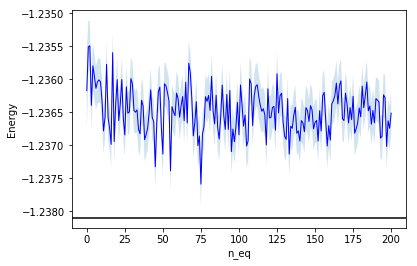

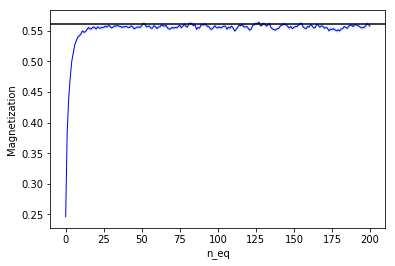

In [9]:
E0 = -1.2381
M0 = 0.561

plt.clf()

plt.figure(1)
ax1 = plt.axes()
ax1.plot(step, energy, color="blue", linewidth=1)
ax1.axhline(E0, color="black")
ax1.fill_between(step, energy-err_energy, energy+err_energy, alpha=0.2)
ax1.set_xlabel("n_eq")
ax1.set_ylabel("Energy")

plt.figure(2)
ax2 = plt.axes()
ax2.plot(step, mag, linewidth=1, color="blue")
ax2.axhline(M0, color="black")
ax2.fill_between(step, mag-err_mag, mag+err_mag, alpha=0.2)
ax2.set_xlabel("n_eq")
ax2.set_ylabel("Magnetization")

You can see a brief transient period in each observable, before the state of the
machine "warms up" to equilibrium.  After that, the values fluctuate around the
calculated mean.